# EEG_Classification
by Jacky Dai, Chanh Tran, Alan Yu, Cody England

Setup

In [ ]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision.transforms import v2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a folder in your drive called ECE147. Make another folder in that folder called project. Add in the data files from Bruinlearn to the project folder.

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/ECE147/project")

#from models import CNN
#from solver import *
#from utils import to_categorical

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
data_directory_path =  "/content/drive/MyDrive/ECE147/project"

X_test = np.load(os.path.join(data_directory_path, "X_test.npy"))
y_test = np.load(os.path.join(data_directory_path,"y_test.npy"))
person_train_valid = np.load(os.path.join(data_directory_path,"person_train_valid.npy"))
X_train_valid = np.load(os.path.join(data_directory_path,"X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_directory_path,"y_train_valid.npy"))
person_test = np.load(os.path.join(data_directory_path,"person_test.npy"))

y_train_valid -= 769
y_test -= 769


Visualize

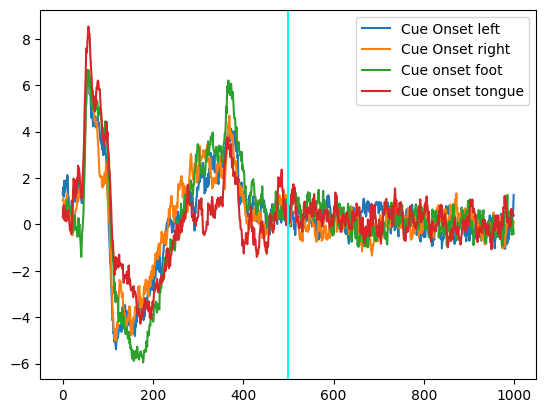

In [ ]:
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [ ]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,900)
    X = X[:,:,0:900]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.3, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,900)
    X = X[:,:,0:900]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X




Single or all subjects

In [ ]:
single = False # <------------ change to False for all training on all subjects

if single:
  ind_valid = np.random.choice(198, 50, replace=False)
  ind_train = np.array(list(set(range(198)).difference(set(ind_valid))))
  # ind_test = np.arange(50)
  # X_test = X_test[ind_test]
  # y_test = y_test[ind_test]
else:
  ind_valid = np.random.choice(2115, 250, replace=False)
  ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

In [ ]:

## Preprocessing the dataset


# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

x_train_prep, y_train_prep = train_data_prep(x_train,y_train,2,2,True)
x_test_prep = test_data_prep(X_test)
print("===========")
print('Shape of training set:',x_train_prep.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train_prep.shape)
print('Shape of validation labels:',y_valid.shape)

# Adding width of the segment to be 1

x_valid = test_data_prep(x_valid)

x_train = x_train_prep.reshape(x_train_prep.shape[0], x_train_prep.shape[1], x_train_prep.shape[2], 1).astype(np.float32)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1).astype(np.float32)
x_test = x_test_prep.reshape(x_test_prep.shape[0], x_test_prep.shape[1], x_test_prep.shape[2], 1).astype(np.float32)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

y_train = y_train_prep

Shape of training set: (1865, 22, 1000)
Shape of validation set: (250, 22, 1000)
Shape of training labels: (1865,)
Shape of validation labels: (250,)
Shape of X after trimming: (1865, 22, 900)
Shape of X after maxpooling: (1865, 22, 450)
Shape of X after averaging+noise and concatenating: (3730, 22, 450)
Shape of X after subsampling and concatenating: (7460, 22, 450)
Shape of Y: (7460,)
Shape of X after trimming: (443, 22, 900)
Shape of X after maxpooling: (443, 22, 450)
Shape of training set: (7460, 22, 450)
Shape of validation set: (250, 22, 1000)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of X after trimming: (250, 22, 900)
Shape of X after maxpooling: (250, 22, 450)
Shape of training set after adding width info: (7460, 22, 450, 1)
Shape of validation set after adding width info: (250, 22, 450, 1)
Shape of test set after adding width info: (443, 22, 450, 1)


In [ ]:
# Data Loading...
from torch.utils.data import TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_tens, y_train_tens = torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device)
X_val_tens, y_val_tens = torch.from_numpy(x_valid).to(device), torch.from_numpy(y_valid).to(device)
X_test_tens, y_test_tens = torch.from_numpy(x_test).to(device), torch.from_numpy(y_test).to(device)

dataset_train = TensorDataset(X_train_tens, y_train_tens)
dataset_val = TensorDataset(X_val_tens, y_val_tens)
dataset_test = TensorDataset(X_test_tens, y_test_tens)

batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


# MODELS

## CNN

In [ ]:
# !pip install torchinfo
!pip install graphviz

In [ ]:
from torchviz import make_dot

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(

            # Input: N x 22 x 450 x 1

            # Conv Block 1
            nn.Conv2d(22, 50, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 2
            nn.Conv2d(50, 100, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 3
            nn.Conv2d(100, 150, kernel_size=(7, 1), stride=1, padding=(3,0)),
            nn.BatchNorm2d(num_features=150, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),
            # nn.Flatten(start_dim=2),

            # Conv Block 4
            nn.Conv2d(150, 200, kernel_size=(5, 1), stride=1, padding=(2,0)),
            nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),

            # Conv Block 5
            nn.Conv2d(200, 250, kernel_size=(3, 1), stride=1, padding=(1,0)),
            nn.BatchNorm2d(num_features=250, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),
            nn.Flatten(start_dim=2),

        )
        # self.lstm1 = nn.LSTM(input_size=25, hidden_size=4,batch_first=True,dropout=0.2)
        self.fc1 = nn.Linear(1500,4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.cnn(x)
        # x, _ = self.lstm1(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [ ]:
from torchinfo import summary
test = CNN() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [3, 4]                    --
├─Sequential: 1-1                        [3, 250, 6]               --
│    └─Conv2d: 2-1                       [3, 50, 450, 1]           9,950
│    └─BatchNorm2d: 2-2                  [3, 50, 450, 1]           100
│    └─ELU: 2-3                          [3, 50, 450, 1]           --
│    └─MaxPool2d: 2-4                    [3, 50, 150, 1]           --
│    └─Dropout: 2-5                      [3, 50, 150, 1]           --
│    └─Conv2d: 2-6                       [3, 100, 150, 1]          45,100
│    └─BatchNorm2d: 2-7                  [3, 100, 150, 1]          200
│    └─ELU: 2-8                          [3, 100, 150, 1]          --
│    └─MaxPool2d: 2-9                    [3, 100, 50, 1]           --
│    └─Dropout: 2-10                     [3, 100, 50, 1]           --
│    └─Conv2d: 2-11                      [3, 150, 50, 1]           105,150
│

In [ ]:
# x = torch.randn(3,22, 450, 1).to(device)
# y = test(x)
# import graphviz
# dot = make_dot(y.mean(), params=dict(test.named_parameters()))
# dot.format = 'png'
# dot.render("/content/drive/MyDrive/ECE147/project/cnn")


'/content/drive/MyDrive/ECE147/project/cnn.png'

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size=450, hidden_size=50, num_layers=1):
      super(LSTM, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
      self.fc = nn.Sequential(
            nn.Linear(1100, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
      )
      self.flat = nn.Flatten()
  def forward(self, x):
      batch_size = x.size(0)
      x = x.view(batch_size, -1, self.input_size)  # Reshape to (batch_size, sequence_length, input_size)
      x, _ = self.lstm(x)
      x = self.flat(x)
      x = self.fc(x)

      return x

In [ ]:
from torchinfo import summary
test = LSTM() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [3, 4]                    --
├─LSTM: 1-1                              [3, 22, 50]               100,400
├─Flatten: 1-2                           [3, 1100]                 --
├─Sequential: 1-3                        [3, 4]                    --
│    └─Linear: 2-1                       [3, 54]                   59,454
│    └─BatchNorm1d: 2-2                  [3, 54]                   108
│    └─ReLU: 2-3                         [3, 54]                   --
│    └─Dropout: 2-4                      [3, 54]                   --
│    └─Linear: 2-5                       [3, 44]                   2,420
│    └─BatchNorm1d: 2-6                  [3, 44]                   88
│    └─ReLU: 2-7                         [3, 44]                   --
│    └─Linear: 2-8                       [3, 4]                    180
Total params: 162,650
Trainable params: 162,650
Non-trainable params: 0

## CNN + LSTM (current best model)

In [ ]:
class CNN_LSTM(nn.Module):

    def __init__(self):
        super(CNN_LSTM, self).__init__()

        self.cnn = nn.Sequential(

            # Input: N x 22 x 450 x 1

            # Conv Block 1
            nn.Conv2d(22, 50, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 2
            nn.Conv2d(50, 100, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 3
            nn.Conv2d(100, 150, kernel_size=(7, 1), stride=1, padding=(3,0)),
            nn.BatchNorm2d(num_features=150, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),
            nn.Flatten(start_dim=2),


        )
        self.lstm1 = nn.LSTM(input_size=25, hidden_size=4,batch_first=True,dropout=0.2)
        self.fc1 = nn.Linear(600,4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.cnn(x)
        x, _ = self.lstm1(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [ ]:
# !pip install torchinfo

In [ ]:
from torchinfo import summary
test = CNN_LSTM() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
CNN_LSTM                                 [3, 4]                    --
├─Sequential: 1-1                        [3, 150, 25]              --
│    └─Conv2d: 2-1                       [3, 50, 450, 1]           9,950
│    └─BatchNorm2d: 2-2                  [3, 50, 450, 1]           100
│    └─ELU: 2-3                          [3, 50, 450, 1]           --
│    └─MaxPool2d: 2-4                    [3, 50, 150, 1]           --
│    └─Dropout: 2-5                      [3, 50, 150, 1]           --
│    └─Conv2d: 2-6                       [3, 100, 150, 1]          45,100
│    └─BatchNorm2d: 2-7                  [3, 100, 150, 1]          200
│    └─ELU: 2-8                          [3, 100, 150, 1]          --
│    └─MaxPool2d: 2-9                    [3, 100, 50, 1]           --
│    └─Dropout: 2-10                     [3, 100, 50, 1]           --
│    └─Conv2d: 2-11                      [3, 150, 50, 1]           105,150
│

In [ ]:
class CNN_test(nn.Module):

    def __init__(self):
        super(CNN_test, self).__init__()

        self.cnn = nn.Sequential(

            # Input: N x 22 x 450 x 1

            # Conv Block 1
            nn.Conv2d(22, 50, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 2
            nn.Conv2d(50, 100, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 3
            nn.Conv2d(100, 150, kernel_size=(7, 1), stride=1, padding=(3,0)),
            nn.BatchNorm2d(num_features=150, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),
            # nn.Flatten(start_dim=2),

            # Conv Block 4
            nn.Conv2d(150, 200, kernel_size=(5, 1), stride=1, padding=(2,0)),
            nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),

            # Conv Block 5
            nn.Conv2d(200, 250, kernel_size=(3, 1), stride=1, padding=(1,0)),
            nn.BatchNorm2d(num_features=250, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),

            nn.Flatten(start_dim=2),


        )
        self.lstm1 = nn.LSTM(input_size=6, hidden_size=4,batch_first=True,dropout=0.4)
        self.fc1 = nn.Linear(1000,4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.cnn(x)
        x, _ = self.lstm1(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [ ]:
from torchinfo import summary
test = CNN_test() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
CNN_test                                 [3, 4]                    --
├─Sequential: 1-1                        [3, 250, 6]               --
│    └─Conv2d: 2-1                       [3, 50, 450, 1]           9,950
│    └─BatchNorm2d: 2-2                  [3, 50, 450, 1]           100
│    └─ELU: 2-3                          [3, 50, 450, 1]           --
│    └─MaxPool2d: 2-4                    [3, 50, 150, 1]           --
│    └─Dropout: 2-5                      [3, 50, 150, 1]           --
│    └─Conv2d: 2-6                       [3, 100, 150, 1]          45,100
│    └─BatchNorm2d: 2-7                  [3, 100, 150, 1]          200
│    └─ELU: 2-8                          [3, 100, 150, 1]          --
│    └─MaxPool2d: 2-9                    [3, 100, 50, 1]           --
│    └─Dropout: 2-10                     [3, 100, 50, 1]           --
│    └─Conv2d: 2-11                      [3, 150, 50, 1]           105,150
│

## CNN + Transformer(pretty bad)

In [ ]:
class CNNTrans(nn.Module):

    def __init__(self):
        super(CNNTrans, self).__init__()

        self.cnn = nn.Sequential(

            # Input: N x 22 x 400 x 1

            # Conv Block 1
            nn.Conv2d(22, 25, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.BatchNorm2d(num_features=25, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(p=0.5),

            # Conv Block 2
            nn.Conv2d(25, 50, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(p=0.5),


            # Conv Block 3
            nn.Conv2d(50, 100, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(p=0.5),

            # Conv Block 4
            nn.Conv2d(100, 200, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.BatchNorm2d(num_features=200, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(p=0.5),

            nn.Flatten(),

            #FC Layer 1
            nn.Linear(1200, 40),
            nn.Unflatten(1, (1,40)),

        )
        self.transformer = nn.Transformer(d_model=40, nhead=4, num_encoder_layers=1)
        self.fc1 = nn.Linear(40,4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1, 40)
        # Transformer expects (seq_len, batch_size, embedding_dim)
        src = x.permute(1, 0, 2)
        tgt = torch.rand_like(src)  # Example target input
        x = self.transformer(src, tgt)
        x = x.permute(1, 0, 2)  # Revert back to (batch_size, seq_len, embedding_dim)

        x = self.flat(x)
        x = self.fc1(x)
        return x

In [ ]:
from torchinfo import summary
test = CNNTrans() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                             Output Shape              Param #
CNNTrans                                           [3, 4]                    --
├─Sequential: 1-1                                  [3, 1, 40]                --
│    └─Conv2d: 2-1                                 [3, 25, 450, 1]           13,775
│    └─ReLU: 2-2                                   [3, 25, 450, 1]           --
│    └─MaxPool2d: 2-3                              [3, 25, 150, 1]           --
│    └─BatchNorm2d: 2-4                            [3, 25, 150, 1]           50
│    └─Dropout: 2-5                                [3, 25, 150, 1]           --
│    └─Conv2d: 2-6                                 [3, 50, 150, 1]           31,300
│    └─ReLU: 2-7                                   [3, 50, 150, 1]           --
│    └─MaxPool2d: 2-8                              [3, 50, 50, 1]            --
│    └─BatchNorm2d: 2-9                            [3, 50, 50, 1]            100
│    └─Dropout: 2-10      

## GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size=450, hidden_size=50, num_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define GRU layer


        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(1100, 54),
            nn.BatchNorm1d(num_features=54, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.4),
            nn.Linear(54, 44),
            nn.BatchNorm1d(num_features=44, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(44, 4)
        )
        self.flat = nn.Flatten()
    def forward(self, x):
        # Reshape input to fit GRU layer
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.input_size)  # Reshape to (batch_size, sequence_length, input_size)

        # Forward pass through GRU layer
        x, _ = self.gru(x)
        x = self.flat(x)
        x = self.fc(x)

        return x


In [ ]:
from torchinfo import summary
test = GRU() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [3, 4]                    --
├─GRU: 1-1                               [3, 22, 50]               75,300
├─Flatten: 1-2                           [3, 1100]                 --
├─Sequential: 1-3                        [3, 4]                    --
│    └─Linear: 2-1                       [3, 54]                   59,454
│    └─BatchNorm1d: 2-2                  [3, 54]                   108
│    └─ReLU: 2-3                         [3, 54]                   --
│    └─Dropout: 2-4                      [3, 54]                   --
│    └─Linear: 2-5                       [3, 44]                   2,420
│    └─BatchNorm1d: 2-6                  [3, 44]                   88
│    └─ReLU: 2-7                         [3, 44]                   --
│    └─Linear: 2-8                       [3, 4]                    180
Total params: 137,550
Trainable params: 137,550
Non-trainable params: 0


## CNN + GRU

In [ ]:
class CNN_GRU(nn.Module):

    def __init__(self):
        super(CNN_GRU, self).__init__()

        self.cnn = nn.Sequential(

            # Input: N x 22 x 450 x 1

            # Conv Block 1
            nn.Conv2d(22, 50, kernel_size=(9, 3), stride=1, padding=(4,1)),
            nn.BatchNorm2d(num_features=50, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 2
            nn.Conv2d(50, 100, kernel_size=(9, 1), stride=1, padding=(4,0)),
            nn.BatchNorm2d(num_features=100, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1,0)),
            nn.Dropout(p=0.5),

            # Conv Block 3
            nn.Conv2d(100, 150, kernel_size=(7, 1), stride=1, padding=(3,0)),
            nn.BatchNorm2d(num_features=150, eps=1e-05, momentum=0.2, affine=True),
            nn.ELU(),
            nn.MaxPool2d((2, 1), stride=(2, 1),padding=(0,0)),
            nn.Dropout(p=0.5),
            nn.Flatten(start_dim=2),


        )
        self.gru = nn.GRU(input_size=25, hidden_size=4,batch_first=True,dropout=0.2)
        self.fc1 = nn.Linear(600,4)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.cnn(x)
        x, _ = self.gru(x)
        x = self.flat(x)
        x = self.fc1(x)
        return x

In [ ]:
test = CNN_GRU() # make instance
summary(test, input_size=(3,22, 450, 1)) # change this if inputs are diff

Layer (type:depth-idx)                   Output Shape              Param #
CNN_GRU                                  [3, 4]                    --
├─Sequential: 1-1                        [3, 150, 25]              --
│    └─Conv2d: 2-1                       [3, 50, 450, 1]           29,750
│    └─BatchNorm2d: 2-2                  [3, 50, 450, 1]           100
│    └─ELU: 2-3                          [3, 50, 450, 1]           --
│    └─MaxPool2d: 2-4                    [3, 50, 150, 1]           --
│    └─Dropout: 2-5                      [3, 50, 150, 1]           --
│    └─Conv2d: 2-6                       [3, 100, 150, 1]          45,100
│    └─BatchNorm2d: 2-7                  [3, 100, 150, 1]          200
│    └─ELU: 2-8                          [3, 100, 150, 1]          --
│    └─MaxPool2d: 2-9                    [3, 100, 50, 1]           --
│    └─Dropout: 2-10                     [3, 100, 50, 1]           --
│    └─Conv2d: 2-11                      [3, 150, 50, 1]           105,150


## Training and Metrics functions

In [ ]:
from sklearn.metrics import cohen_kappa_score

def evaluate_kappa(model, dataloader):
    actual = []
    predicted = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            if use_gpu:
                batch_x = batch_x.cuda()
            predictions = model(batch_x)
            predictions = torch.argmax(predictions, dim=1)
            actual.append(batch_y.cpu().numpy())
            predicted.append(predictions.cpu().numpy())
    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)
    return cohen_kappa_score(actual, predicted)


def evaluate_acc(model, dataloader):
    model.eval()
    total_acc = 0.0
    for batch_X, batch_y in dataloader:
      outputs = model(batch_X)
      predictions = torch.argmax(outputs, dim=1)
      total_acc += (predictions==batch_y).sum()
    return float(total_acc / len(dataloader.dataset))


def train_model(hist,model, train_loader, optimizer, num_epochs=2, use_gpu=False, lr=0.001, momentum=0.9):
  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for data in tqdm(train_loader):
        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        if use_gpu:
          inputs = inputs.cuda()
          labels = labels.cuda()
        else:
          inputs = inputs.cpu()
          labels = labels.cpu()
        optimizer.zero_grad()

        predictions = net.forward(inputs)
        labels=labels.to(torch.int64)
        loss = criterion(predictions,labels)
        loss.backward()
        optimizer.step()
    train_acc = evaluate_acc(model,train_loader)
    val_acc = evaluate_acc(model,val_loader)
    hist['train'].append(train_acc)
    hist['val'].append(val_acc)
    print(f"Epoch {epoch+1}: Training Accuracy: {train_acc}")
    print(f"Epoch {epoch+1}: Validation Accuracy: {val_acc}")


  print('Training Complete')
  return hist, num_epochs

def plot(hist, num_epochs):
    train_hist = np.array(hist['train'])
    val_hist = np.array(hist['val'])
    plt.plot(range(len(hist['train'])),train_hist, range(len(hist['val'])), val_hist)

    plt.legend(['Train','Validation'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
def compute_confusion_matrix(model, dataloader):
  y_pred = []
  y_true = []

  # Evaluate the model on the test data.
  model.eval()
  for inputs, labels in dataloader:
    output = model(inputs)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
  cf_matrix = confusion_matrix(y_true, y_pred)
  classes = ("left hand","right hand","feets","tongue")
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
  plt.figure(figsize = (4,4))
  sn.heatmap(df_cm, annot=True)
  plt.show()

# Training/Eval
This only runs 2 epochs to see if it works.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 150/150 [00:01<00:00, 90.68it/s] 


Epoch 1: Training Accuracy: 0.3166219890117645
Epoch 1: Validation Accuracy: 0.25200000405311584


100%|██████████| 150/150 [00:01<00:00, 94.34it/s]


Epoch 2: Training Accuracy: 0.4312332272529602
Epoch 2: Validation Accuracy: 0.4000000059604645
Training Complete


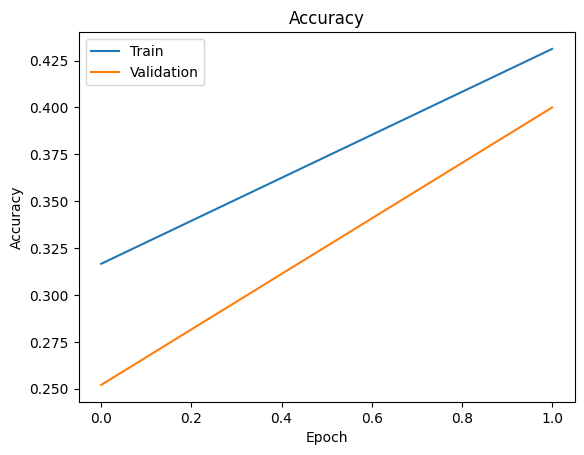

Test Accuracy: 0.3972912132740021


In [ ]:
hist = {}
hist['train'] = []
hist['val'] = []


net = CNN_LSTM().cuda() # change model here
optimizer = optim.Adam(net.parameters(), lr=5e-4,weight_decay=1e-5)
#optimizer = optim.SGD(net.parameters(), momentum=0.8,lr=1e-3,weight_decay=1e-5)
hist, num_epochs = train_model(hist,net,train_loader,optimizer,num_epochs=2,use_gpu=True)
plot(hist, num_epochs)
print("Test Accuracy:", evaluate_acc(net,test_loader))

100%|██████████| 150/150 [00:01<00:00, 146.00it/s]


Epoch 1: Training Accuracy: 0.5148793458938599
Epoch 1: Validation Accuracy: 0.4280000329017639


100%|██████████| 150/150 [00:01<00:00, 147.96it/s]


Epoch 2: Training Accuracy: 0.5367292165756226
Epoch 2: Validation Accuracy: 0.5


100%|██████████| 150/150 [00:00<00:00, 208.51it/s]


Epoch 3: Training Accuracy: 0.5837801694869995
Epoch 3: Validation Accuracy: 0.5160000324249268


100%|██████████| 150/150 [00:00<00:00, 211.96it/s]


Epoch 4: Training Accuracy: 0.6230562925338745
Epoch 4: Validation Accuracy: 0.527999997138977


100%|██████████| 150/150 [00:00<00:00, 213.64it/s]


Epoch 5: Training Accuracy: 0.6682305335998535
Epoch 5: Validation Accuracy: 0.5520000457763672


100%|██████████| 150/150 [00:00<00:00, 201.74it/s]


Epoch 6: Training Accuracy: 0.7100536227226257
Epoch 6: Validation Accuracy: 0.6160000562667847


100%|██████████| 150/150 [00:00<00:00, 208.73it/s]


Epoch 7: Training Accuracy: 0.7126005291938782
Epoch 7: Validation Accuracy: 0.612000048160553


100%|██████████| 150/150 [00:00<00:00, 211.10it/s]


Epoch 8: Training Accuracy: 0.7485254406929016
Epoch 8: Validation Accuracy: 0.6680000424385071


100%|██████████| 150/150 [00:00<00:00, 214.40it/s]


Epoch 9: Training Accuracy: 0.7671581506729126
Epoch 9: Validation Accuracy: 0.6440000534057617


100%|██████████| 150/150 [00:00<00:00, 214.47it/s]


Epoch 10: Training Accuracy: 0.7861930131912231
Epoch 10: Validation Accuracy: 0.6720000505447388


100%|██████████| 150/150 [00:00<00:00, 211.22it/s]


Epoch 11: Training Accuracy: 0.7985254526138306
Epoch 11: Validation Accuracy: 0.7320000529289246


100%|██████████| 150/150 [00:00<00:00, 179.07it/s]


Epoch 12: Training Accuracy: 0.8336461186408997
Epoch 12: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 150.31it/s]


Epoch 13: Training Accuracy: 0.8396782875061035
Epoch 13: Validation Accuracy: 0.7360000610351562


100%|██████████| 150/150 [00:00<00:00, 156.53it/s]


Epoch 14: Training Accuracy: 0.8684986233711243
Epoch 14: Validation Accuracy: 0.6880000233650208


100%|██████████| 150/150 [00:00<00:00, 201.44it/s]


Epoch 15: Training Accuracy: 0.8701072335243225
Epoch 15: Validation Accuracy: 0.7360000610351562


100%|██████████| 150/150 [00:00<00:00, 205.92it/s]


Epoch 16: Training Accuracy: 0.8733243942260742
Epoch 16: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 208.05it/s]


Epoch 17: Training Accuracy: 0.8643431663513184
Epoch 17: Validation Accuracy: 0.6880000233650208


100%|██████████| 150/150 [00:00<00:00, 197.22it/s]


Epoch 18: Training Accuracy: 0.8941018581390381
Epoch 18: Validation Accuracy: 0.6960000395774841


100%|██████████| 150/150 [00:00<00:00, 212.56it/s]


Epoch 19: Training Accuracy: 0.9139410257339478
Epoch 19: Validation Accuracy: 0.7520000338554382


100%|██████████| 150/150 [00:00<00:00, 199.18it/s]


Epoch 20: Training Accuracy: 0.9277479648590088
Epoch 20: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 178.27it/s]


Epoch 21: Training Accuracy: 0.9331098794937134
Epoch 21: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:01<00:00, 146.99it/s]


Epoch 22: Training Accuracy: 0.9312332272529602
Epoch 22: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:01<00:00, 137.06it/s]


Epoch 23: Training Accuracy: 0.9361929893493652
Epoch 23: Validation Accuracy: 0.7240000367164612


100%|██████████| 150/150 [00:01<00:00, 147.60it/s]


Epoch 24: Training Accuracy: 0.9463806748390198
Epoch 24: Validation Accuracy: 0.7240000367164612


100%|██████████| 150/150 [00:00<00:00, 159.94it/s]


Epoch 25: Training Accuracy: 0.9426273107528687
Epoch 25: Validation Accuracy: 0.7520000338554382


100%|██████████| 150/150 [00:00<00:00, 203.08it/s]


Epoch 26: Training Accuracy: 0.9432975649833679
Epoch 26: Validation Accuracy: 0.7360000610351562


100%|██████████| 150/150 [00:00<00:00, 209.42it/s]


Epoch 27: Training Accuracy: 0.9506702423095703
Epoch 27: Validation Accuracy: 0.7120000123977661


100%|██████████| 150/150 [00:00<00:00, 202.48it/s]


Epoch 28: Training Accuracy: 0.9632707834243774
Epoch 28: Validation Accuracy: 0.7440000176429749


100%|██████████| 150/150 [00:00<00:00, 203.48it/s]


Epoch 29: Training Accuracy: 0.9576407670974731
Epoch 29: Validation Accuracy: 0.7680000066757202


100%|██████████| 150/150 [00:00<00:00, 204.42it/s]


Epoch 30: Training Accuracy: 0.9726541638374329
Epoch 30: Validation Accuracy: 0.7520000338554382


100%|██████████| 150/150 [00:00<00:00, 201.55it/s]


Epoch 31: Training Accuracy: 0.9808310866355896
Epoch 31: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 201.11it/s]


Epoch 32: Training Accuracy: 0.9694370031356812
Epoch 32: Validation Accuracy: 0.7600000500679016


100%|██████████| 150/150 [00:00<00:00, 210.76it/s]


Epoch 33: Training Accuracy: 0.9785522818565369
Epoch 33: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 199.10it/s]


Epoch 34: Training Accuracy: 0.9789544343948364
Epoch 34: Validation Accuracy: 0.7440000176429749


100%|██████████| 150/150 [00:01<00:00, 143.83it/s]


Epoch 35: Training Accuracy: 0.9805629849433899
Epoch 35: Validation Accuracy: 0.7640000581741333


100%|██████████| 150/150 [00:00<00:00, 150.40it/s]


Epoch 36: Training Accuracy: 0.9871313571929932
Epoch 36: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:01<00:00, 125.52it/s]


Epoch 37: Training Accuracy: 0.987265408039093
Epoch 37: Validation Accuracy: 0.7440000176429749


100%|██████████| 150/150 [00:00<00:00, 201.82it/s]


Epoch 38: Training Accuracy: 0.9914209246635437
Epoch 38: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 206.37it/s]


Epoch 39: Training Accuracy: 0.979356586933136
Epoch 39: Validation Accuracy: 0.7320000529289246


100%|██████████| 150/150 [00:00<00:00, 205.83it/s]


Epoch 40: Training Accuracy: 0.9875335097312927
Epoch 40: Validation Accuracy: 0.7760000228881836


100%|██████████| 150/150 [00:00<00:00, 202.50it/s]


Epoch 41: Training Accuracy: 0.9857908487319946
Epoch 41: Validation Accuracy: 0.7520000338554382


100%|██████████| 150/150 [00:00<00:00, 209.62it/s]


Epoch 42: Training Accuracy: 0.9955763816833496
Epoch 42: Validation Accuracy: 0.7640000581741333


100%|██████████| 150/150 [00:00<00:00, 202.82it/s]


Epoch 43: Training Accuracy: 0.9928954243659973
Epoch 43: Validation Accuracy: 0.7240000367164612


100%|██████████| 150/150 [00:00<00:00, 205.25it/s]


Epoch 44: Training Accuracy: 0.9903485178947449
Epoch 44: Validation Accuracy: 0.7600000500679016


100%|██████████| 150/150 [00:00<00:00, 210.13it/s]


Epoch 45: Training Accuracy: 0.9898123145103455
Epoch 45: Validation Accuracy: 0.7360000610351562


100%|██████████| 150/150 [00:00<00:00, 170.31it/s]


Epoch 46: Training Accuracy: 0.9927613735198975
Epoch 46: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:01<00:00, 147.28it/s]


Epoch 47: Training Accuracy: 0.9835120439529419
Epoch 47: Validation Accuracy: 0.7280000448226929


100%|██████████| 150/150 [00:00<00:00, 171.14it/s]


Epoch 48: Training Accuracy: 0.9923592209815979
Epoch 48: Validation Accuracy: 0.7240000367164612


100%|██████████| 150/150 [00:00<00:00, 207.73it/s]


Epoch 49: Training Accuracy: 0.997050940990448
Epoch 49: Validation Accuracy: 0.7760000228881836


100%|██████████| 150/150 [00:00<00:00, 208.26it/s]


Epoch 50: Training Accuracy: 0.996112585067749
Epoch 50: Validation Accuracy: 0.7600000500679016
Training Complete


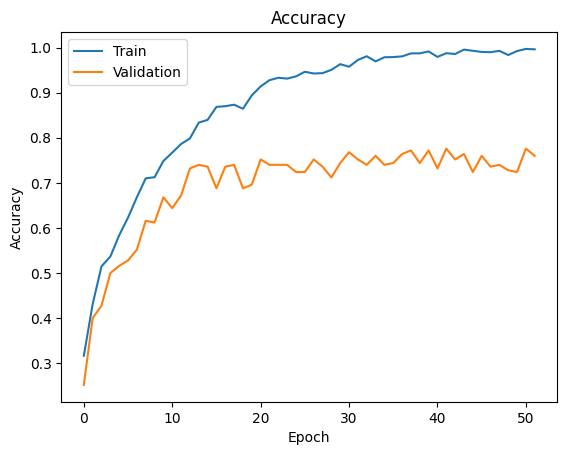

Test Accuracy: 0.7065463066101074


In [ ]:
#optimizer = optim.Adam(net.parameters(), lr=1e-3,weight_decay=1e-5)
hist, num_epochs = train_model(hist,net,train_loader,optimizer,num_epochs=50,use_gpu=True)
plot(hist, num_epochs)
print("Test Accuracy:", evaluate_acc(net,test_loader))

if you want to keep training this next block. Plot will automatically grow.

100%|██████████| 150/150 [00:00<00:00, 193.38it/s]


Epoch 1: Training Accuracy: 0.9949061274528503
Epoch 1: Validation Accuracy: 0.7600000500679016


100%|██████████| 150/150 [00:00<00:00, 203.60it/s]


Epoch 2: Training Accuracy: 0.9994637966156006
Epoch 2: Validation Accuracy: 0.7680000066757202


100%|██████████| 150/150 [00:00<00:00, 205.41it/s]


Epoch 3: Training Accuracy: 0.9969168901443481
Epoch 3: Validation Accuracy: 0.7880000472068787


100%|██████████| 150/150 [00:00<00:00, 205.75it/s]


Epoch 4: Training Accuracy: 0.9983913898468018
Epoch 4: Validation Accuracy: 0.800000011920929


100%|██████████| 150/150 [00:00<00:00, 205.24it/s]


Epoch 5: Training Accuracy: 0.9971849918365479
Epoch 5: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 206.70it/s]


Epoch 6: Training Accuracy: 0.9989275932312012
Epoch 6: Validation Accuracy: 0.7680000066757202


100%|██████████| 150/150 [00:00<00:00, 152.01it/s]


Epoch 7: Training Accuracy: 0.9997318983078003
Epoch 7: Validation Accuracy: 0.7800000309944153


100%|██████████| 150/150 [00:01<00:00, 149.96it/s]


Epoch 8: Training Accuracy: 0.999061644077301
Epoch 8: Validation Accuracy: 0.7600000500679016


100%|██████████| 150/150 [00:00<00:00, 200.58it/s]


Epoch 9: Training Accuracy: 0.9995978474617004
Epoch 9: Validation Accuracy: 0.7760000228881836


100%|██████████| 150/150 [00:00<00:00, 212.96it/s]


Epoch 10: Training Accuracy: 0.9946380853652954
Epoch 10: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 213.87it/s]


Epoch 11: Training Accuracy: 0.9975871443748474
Epoch 11: Validation Accuracy: 0.7800000309944153


100%|██████████| 150/150 [00:00<00:00, 216.12it/s]


Epoch 12: Training Accuracy: 0.9973190426826477
Epoch 12: Validation Accuracy: 0.7600000500679016


100%|██████████| 150/150 [00:00<00:00, 211.91it/s]


Epoch 13: Training Accuracy: 0.9994637966156006
Epoch 13: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 217.39it/s]


Epoch 14: Training Accuracy: 0.9995978474617004
Epoch 14: Validation Accuracy: 0.784000039100647


100%|██████████| 150/150 [00:00<00:00, 206.60it/s]


Epoch 15: Training Accuracy: 0.9995978474617004
Epoch 15: Validation Accuracy: 0.7800000309944153


100%|██████████| 150/150 [00:00<00:00, 209.99it/s]


Epoch 16: Training Accuracy: 0.9997318983078003
Epoch 16: Validation Accuracy: 0.7560000419616699


100%|██████████| 150/150 [00:00<00:00, 207.47it/s]


Epoch 17: Training Accuracy: 0.9994637966156006
Epoch 17: Validation Accuracy: 0.7800000309944153


100%|██████████| 150/150 [00:00<00:00, 202.36it/s]


Epoch 18: Training Accuracy: 0.9987935423851013
Epoch 18: Validation Accuracy: 0.7920000553131104


100%|██████████| 150/150 [00:01<00:00, 144.66it/s]


Epoch 19: Training Accuracy: 0.9998659491539001
Epoch 19: Validation Accuracy: 0.7680000066757202


100%|██████████| 150/150 [00:01<00:00, 142.91it/s]


Epoch 20: Training Accuracy: 0.9998659491539001
Epoch 20: Validation Accuracy: 0.7920000553131104


100%|██████████| 150/150 [00:00<00:00, 204.89it/s]


Epoch 21: Training Accuracy: 0.9989275932312012
Epoch 21: Validation Accuracy: 0.7880000472068787


100%|██████████| 150/150 [00:00<00:00, 210.78it/s]


Epoch 22: Training Accuracy: 0.9995978474617004
Epoch 22: Validation Accuracy: 0.7920000553131104


100%|██████████| 150/150 [00:00<00:00, 198.18it/s]


Epoch 23: Training Accuracy: 0.9997318983078003
Epoch 23: Validation Accuracy: 0.796000063419342


100%|██████████| 150/150 [00:00<00:00, 209.36it/s]


Epoch 24: Training Accuracy: 0.9994637966156006
Epoch 24: Validation Accuracy: 0.784000039100647


100%|██████████| 150/150 [00:00<00:00, 211.43it/s]


Epoch 25: Training Accuracy: 0.9998659491539001
Epoch 25: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 209.87it/s]


Epoch 26: Training Accuracy: 0.9997318983078003
Epoch 26: Validation Accuracy: 0.7400000095367432


100%|██████████| 150/150 [00:00<00:00, 209.37it/s]


Epoch 27: Training Accuracy: 0.9969168901443481
Epoch 27: Validation Accuracy: 0.7240000367164612


100%|██████████| 150/150 [00:00<00:00, 203.17it/s]


Epoch 28: Training Accuracy: 0.9995978474617004
Epoch 28: Validation Accuracy: 0.7520000338554382


100%|██████████| 150/150 [00:00<00:00, 198.10it/s]


Epoch 29: Training Accuracy: 0.9995978474617004
Epoch 29: Validation Accuracy: 0.7760000228881836


100%|██████████| 150/150 [00:00<00:00, 195.93it/s]


Epoch 30: Training Accuracy: 0.9998659491539001
Epoch 30: Validation Accuracy: 0.7880000472068787


100%|██████████| 150/150 [00:01<00:00, 77.38it/s] 


Epoch 31: Training Accuracy: 0.9998659491539001
Epoch 31: Validation Accuracy: 0.7440000176429749


100%|██████████| 150/150 [00:00<00:00, 194.16it/s]


Epoch 32: Training Accuracy: 0.9991956949234009
Epoch 32: Validation Accuracy: 0.7560000419616699


100%|██████████| 150/150 [00:00<00:00, 209.16it/s]


Epoch 33: Training Accuracy: 1.0
Epoch 33: Validation Accuracy: 0.7560000419616699


100%|██████████| 150/150 [00:00<00:00, 210.47it/s]


Epoch 34: Training Accuracy: 0.9997318983078003
Epoch 34: Validation Accuracy: 0.7800000309944153


100%|██████████| 150/150 [00:00<00:00, 205.97it/s]


Epoch 35: Training Accuracy: 0.9998659491539001
Epoch 35: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 207.19it/s]


Epoch 36: Training Accuracy: 1.0
Epoch 36: Validation Accuracy: 0.800000011920929


100%|██████████| 150/150 [00:00<00:00, 207.28it/s]


Epoch 37: Training Accuracy: 0.9997318983078003
Epoch 37: Validation Accuracy: 0.7480000257492065


100%|██████████| 150/150 [00:00<00:00, 207.26it/s]


Epoch 38: Training Accuracy: 0.9994637966156006
Epoch 38: Validation Accuracy: 0.7560000419616699


100%|██████████| 150/150 [00:00<00:00, 210.49it/s]


Epoch 39: Training Accuracy: 0.9998659491539001
Epoch 39: Validation Accuracy: 0.7560000419616699


100%|██████████| 150/150 [00:00<00:00, 208.21it/s]


Epoch 40: Training Accuracy: 0.9998659491539001
Epoch 40: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 205.21it/s]


Epoch 41: Training Accuracy: 0.9991956949234009
Epoch 41: Validation Accuracy: 0.7760000228881836


100%|██████████| 150/150 [00:01<00:00, 146.48it/s]


Epoch 42: Training Accuracy: 1.0
Epoch 42: Validation Accuracy: 0.7760000228881836


100%|██████████| 150/150 [00:00<00:00, 154.42it/s]


Epoch 43: Training Accuracy: 1.0
Epoch 43: Validation Accuracy: 0.7920000553131104


100%|██████████| 150/150 [00:00<00:00, 204.23it/s]


Epoch 44: Training Accuracy: 0.9994637966156006
Epoch 44: Validation Accuracy: 0.7480000257492065


100%|██████████| 150/150 [00:00<00:00, 208.25it/s]


Epoch 45: Training Accuracy: 0.9998659491539001
Epoch 45: Validation Accuracy: 0.7680000066757202


100%|██████████| 150/150 [00:00<00:00, 203.99it/s]


Epoch 46: Training Accuracy: 1.0
Epoch 46: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 202.53it/s]


Epoch 47: Training Accuracy: 0.9998659491539001
Epoch 47: Validation Accuracy: 0.7720000147819519


100%|██████████| 150/150 [00:00<00:00, 192.40it/s]


Epoch 48: Training Accuracy: 0.9998659491539001
Epoch 48: Validation Accuracy: 0.7560000419616699


100%|██████████| 150/150 [00:00<00:00, 203.49it/s]


Epoch 49: Training Accuracy: 0.9998659491539001
Epoch 49: Validation Accuracy: 0.7640000581741333


100%|██████████| 150/150 [00:00<00:00, 202.02it/s]


Epoch 50: Training Accuracy: 1.0
Epoch 50: Validation Accuracy: 0.7560000419616699
Training Complete


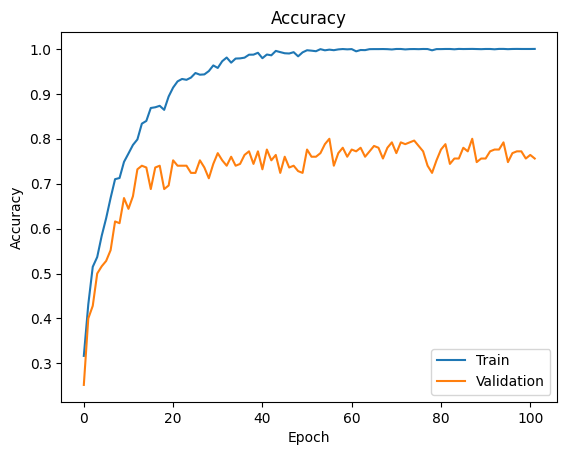

Test Accuracy: 0.7426636815071106


In [ ]:
optimizer_2 = optim.SGD(net.parameters(), momentum=0.8,lr=1e-4,weight_decay=1e-5)

hist, num_epochs = train_model(hist,net,train_loader,optimizer,num_epochs=50,use_gpu=True)
plot(hist, num_epochs)
print("Test Accuracy:", evaluate_acc(net,test_loader))


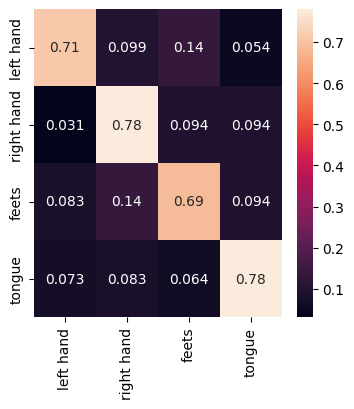

In [ ]:
compute_confusion_matrix(net, test_loader)